Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

1) Use industry returns from [Ken French](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)

2) Forecast (for example) this month's Chemical industry return using last month's returns from all 30 industries 

3) Use LASSO for predictor subset selection over the entire 1960-2016 period to determine that e.g. Beer is predicted by Food, Clothing, Coal

4) Use those predictors and simple linear regression to predict returns

5) Generate portfolios and run backtests.

- Predictor selection - finds same predictors except 2 industries. Possibly use of AICc instead of AIC (don't see an sklearn implementation that uses AICc)

- Prediction by industry - R-squareds line up pretty closely

- Portfolio performance, similar ballpark results. Since prediction is similar but return profile is different, must be some difference in portfolio construction. (am taking equal weight top 6 predicted as long and bottom 6 as short, every month)

- For some reason their mean returns don't line up to geometric mean annualized, they seem to be calculating something different.

- But it does replicate closely and perform well

We also try swapping LinearRegression for sklearn neural network MLPRegressor but it doesn't show an improvement.

 

In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import time 
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import chisquare

import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import plotly as py
# print (py.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1764)
np.random.seed(1764)


In [2]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']

#for ind in industries:
#    data[ind+".3m"] = pd.rolling_mean(data[ind],3)
    
#for ind in industries:
#    data[ind+".6m"] = pd.rolling_mean(data[ind],6)

#for ind in industries:
#    data[ind+".12m"] = pd.rolling_mean(data[ind],12)
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 60)


,Food,Food.lead
yyyymm,,
195912,2.01,-4.49
196001,-4.49,3.35
196002,3.35,-1.67
196003,-1.67,1.17
196004,1.17,8.20
196005,8.20,5.39
196006,5.39,-2.11
196007,-2.11,4.57
196008,4.57,-3.88


In [3]:
# exclude 2017 and later to tie to paper
data = data.loc[data.index[data.index < 201701]]
data = data.loc[data.index[data.index > 195911]]
data


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
yyyymm,,,,,,,,,,,,,,,,,,,,,
195912,2.01,0.35,-3.02,1.64,7.29,0.67,1.87,-1.97,3.08,0.74,...,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98
196001,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,...,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32
196002,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,...,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43
196003,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,...,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55
196004,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,...,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02
196005,8.20,-0.52,2.44,7.28,11.67,7.74,1.74,13.50,3.40,2.10,...,-0.58,-8.07,2.39,3.50,2.17,5.96,3.41,1.03,3.72,6.41
196006,5.39,0.47,4.73,2.24,0.02,6.38,-1.59,-0.40,0.45,4.04,...,-0.03,2.84,-2.02,-4.10,-3.11,-6.16,-2.99,-1.25,0.09,-5.95
196007,-2.11,-0.79,4.60,-4.72,0.23,-0.60,-1.10,-3.99,-6.80,-3.14,...,6.94,5.69,2.71,1.18,1.98,4.51,2.85,2.05,3.47,3.48
196008,4.57,3.24,5.20,7.16,3.63,5.09,3.34,2.29,1.17,-0.84,...,-6.07,-3.53,-7.61,-7.37,-7.07,-8.44,-8.57,-1.90,-5.78,-4.21


In [4]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,...,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,0.690715,0.710613,0.982321,0.701708,0.528277,0.554190,0.669460,0.650905,0.519781,0.667416,...,0.520847,0.694234,0.584175,0.511241,0.582088,0.625562,0.662219,0.702730,0.609810,0.385620
std,4.339811,5.090215,6.061582,7.180918,5.809314,4.759874,6.386027,4.928072,5.518477,7.022552,...,4.628520,6.527984,6.738979,5.055314,5.739306,5.605317,5.349341,6.104515,5.411766,5.815446
min,-18.150000,-20.190000,-25.320000,-33.400000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,...,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000
25%,-1.640000,-2.100000,-2.780000,-3.490000,-2.690000,-2.110000,-2.810000,-2.240000,-2.800000,-3.200000,...,-2.110000,-3.090000,-3.290000,-2.430000,-2.780000,-2.570000,-2.430000,-2.940000,-2.420000,-2.990000
50%,0.740000,0.710000,1.280000,0.890000,0.510000,0.750000,0.690000,0.750000,0.670000,0.630000,...,0.610000,0.970000,0.560000,0.690000,0.860000,0.940000,0.470000,1.030000,0.820000,0.470000
75%,3.120000,3.660000,4.640000,5.310000,3.720000,3.550000,4.310000,3.560000,3.760000,4.490000,...,3.360000,4.290000,4.590000,3.460000,4.060000,3.880000,4.000000,4.330000,4.000000,4.200000
max,19.890000,25.510000,32.380000,34.520000,33.130000,18.220000,31.790000,29.010000,21.680000,59.030000,...,21.220000,23.380000,24.660000,21.000000,18.500000,17.530000,26.490000,27.380000,20.590000,19.960000


In [5]:
# annualized returns don't match Table 1, oddly
# geometric mean, annualized
pd.DataFrame((np.prod(data/100 + 1)**(12.0/len(data))-1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.074020
Beer,0.072005
Smoke,0.100147
Games,0.054031
Books,0.043953
Hshld,0.054098
Clths,0.057170
Hlth,0.065463
Chems,0.044917
Txtls,0.051888


In [6]:
# try this way, arithmetic mean then annualize (not very correct)
#print(pd.DataFrame(((desc.loc['mean']/100+1)**12-1)[:30]))
#nope

# same
pd.DataFrame(((1 + np.mean(data, axis=0)/100)**12 -1)[:30], columns=['Mean Ann. Return'])

,Mean Ann. Return
Food,0.086108
Beer,0.088687
Smoke,0.124460
Games,0.087532
Books,0.065268
Hshld,0.068568
Clths,0.083360
Hlth,0.080966
Chems,0.064188
Txtls,0.083096


In [7]:
#annualized volatility 
pd.DataFrame((desc.loc['std']*np.sqrt(12))[:30].round(2))
# lines up with table 1

,std
Food,15.03
Beer,17.63
Smoke,21.00
Games,24.88
Books,20.12
Hshld,16.49
Clths,22.12
Hlth,17.07
Chems,19.12
Txtls,24.33


In [8]:
# Run LASSO, then OLS on selected variables

# skip last row to better match published r-squared
# looks like they forecast actuals 1960-2016 using 1959m12 to 2016m11
# not exact matches to Table 2 R-squared but almost within rounding error 
X = data.values[:-1,:npredictors]
Y = data.values[:-1,-nresponses:]
nrows = X.shape[0]
X.shape

(684, 30)

In [9]:
def subset_selection(X, Y, model_aic, verbose=False, responses=responses, predictors=predictors):
    
    nrows, npreds = X.shape
    nows, nresps = Y.shape
    coef_dict = []
    
    for response_index in range(nresps):
        y = Y[:,response_index]
        model_aic.fit(X, y)
        predcols = [i for i in range(npreds) if model_aic.coef_[i] !=0]

        #y_response = model_aic.predict(X)
        # print ("In-sample LASSO R-squared: %.6f" % r2_score(y, y_response))
        if verbose and responses:
            print("LASSO variables selected for %s: " % responses[response_index])
            print([predictors[i] for i in predcols])
        
        if not predcols:
            if verbose and responses:
                print("No coefs selected for " + responses[response_index] + ", using all")
                print("---")
            predcols = list(range(npreds))    
            
        # fit OLS vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        coef_dict.append(predcols)
        if verbose and responses and predictors:
            print("Running OLS for " + responses[response_index] + " against " + str([predictors[i] for i in predcols]))
            # col nums of selected responses
            model_ols = LinearRegression()
            model_ols.fit(X[:, predcols], y)
            y_pred = model_ols.predict(X[:, predcols])
            print ("In-sample OLS R-squared: %.2f%%" % (100 * r2_score(y, y_pred)))
            print("---")
            
    return coef_dict

#coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'))
coef_dict = subset_selection(X, Y, LassoLarsIC(criterion='aic'), verbose=True, responses=responses, predictors=predictors)
print(coef_dict)
# These subsets line up closely with Table 2
# except Clths, Whlsl, we get different responses

LASSO variables selected for Food.lead: 
['Clths', 'Coal', 'Util', 'Rtail']
Running OLS for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample OLS R-squared: 2.24%
---
LASSO variables selected for Beer.lead: 
['Food', 'Clths', 'Coal']
Running OLS for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample OLS R-squared: 2.52%
---
LASSO variables selected for Smoke.lead: 
['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
Running OLS for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample OLS R-squared: 6.55%
---
LASSO variables selected for Games.lead: 
['Books', 'Clths', 'Coal', 'Fin']
Running OLS for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample OLS R-squared: 5.05%
---
LASSO variables selected for Books.lead: 
['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
Running OLS for Books.lead against ['Games', 'Books', 'Coal'

In [10]:
# same predictors selected for all but 2 response vars
# use predictors from paper to match results
if True: # turn off/on
    coef_dict_temp = {}
    coef_dict_temp['Food.lead'] = ['Clths', 'Coal', 'Util', 'Rtail']
    coef_dict_temp['Beer.lead'] = ['Food', 'Clths', 'Coal']
    coef_dict_temp['Smoke.lead'] = ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
    coef_dict_temp['Games.lead'] = ['Books', 'Clths', 'Coal', 'Fin']
    coef_dict_temp['Books.lead'] = ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Hshld.lead'] = ['Clths', 'Coal', 'Rtail']
    coef_dict_temp['Clths.lead'] = ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry',  'Coal', 'Oil', 'Util','Telcm', 'Servs', 'BusEq', 'Rtail']
    # Running OLS for Clths against ['Clths', 'Coal', 'Oil', 'Servs', 'Rtail']
    coef_dict_temp['Hlth.lead'] = ['Books', 'Mines', 'Coal', 'Util']
    coef_dict_temp['Chems.lead'] = ['Clths']
    coef_dict_temp['Txtls.lead'] = ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Cnstr.lead'] = ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin']
    coef_dict_temp['Steel.lead'] = ['Fin']
    coef_dict_temp['FabPr.lead'] = ['Trans', 'Fin']
    coef_dict_temp['ElcEq.lead'] = ['Fin']
    coef_dict_temp['Autos.lead'] = ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', 'Rtail', 'Fin']
    coef_dict_temp['Carry.lead'] = ['Trans']
    coef_dict_temp['Mines.lead'] = []
    coef_dict_temp['Coal.lead'] = ['Beer', 'Smoke', 'Books', 'Autos', 'Coal', 'Oil', 'Paper', 'Rtail']
    coef_dict_temp['Oil.lead'] = ['Beer', 'Hlth', 'Carry']
    coef_dict_temp['Util.lead'] = ['Food', 'Beer', 'Smoke', 'Hshld', 'Hlth', 'Cnstr', 'FabPr', 'Carry', 'Mines', 'Oil', 'Util', 'Telcm', 'BusEq', 'Whlsl', 'Fin', 'Other']
    coef_dict_temp['Telcm.lead'] = ['Beer', 'Smoke', 'Books', 'Hshld', 'Cnstr', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Meals', 'Fin']
    coef_dict_temp['Servs.lead'] = ['Smoke', 'Books', 'Steel', 'Oil', 'Util', 'Fin']
    coef_dict_temp['BusEq.lead'] = ['Smoke', 'Books', 'Util']
    coef_dict_temp['Paper.lead'] = ['Clths', 'Coal', 'Oil', 'Rtail', 'Fin']
    coef_dict_temp['Trans.lead'] = ['Fin']
    coef_dict_temp['Whlsl.lead'] = ['Food', 'Beer', 'Smoke', 'Books', 'Hlth', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Fin', 'Other']
    # Running OLS for Whlsl against ['Food', 'Smoke', 'Books', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'Fin', 'Other']
    coef_dict_temp['Rtail.lead'] = ['Rtail']
    coef_dict_temp['Meals.lead'] = ['Smoke', 'Books', 'Clths', 'Steel', 'Carry', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Meals', 'Fin']
    coef_dict_temp['Fin.lead'] = ['Fin']
    coef_dict_temp['Other.lead'] = ['Clths', 'Fin']
    
coef_dict_paper = []
for response in responses:
    print(response, " -> ", coef_dict_temp[response])
    coef_dict_paper.append([predictor_reverse_dict[jstr] for jstr in coef_dict_temp[response]])
print(coef_dict_paper)

('Food.lead', ' -> ', ['Clths', 'Coal', 'Util', 'Rtail'])
('Beer.lead', ' -> ', ['Food', 'Clths', 'Coal'])
('Smoke.lead', ' -> ', ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin'])
('Games.lead', ' -> ', ['Books', 'Clths', 'Coal', 'Fin'])
('Books.lead', ' -> ', ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin'])
('Hshld.lead', ' -> ', ['Clths', 'Coal', 'Rtail'])
('Clths.lead', ' -> ', ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail'])
('Hlth.lead', ' -> ', ['Books', 'Mines', 'Coal', 'Util'])
('Chems.lead', ' -> ', ['Clths'])
('Txtls.lead', ' -> ', ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin'])
('Cnstr.lead', ' -> ', ['Clths', 'Coal', 'Oil', 'Util', 'Trans', 'Rtail', 'Fin'])
('Steel.lead', ' -> ', ['Fin'])
('FabPr.lead', ' -> ', ['Trans', 'Fin'])
('ElcEq.lead', ' -> ', ['Fin'])
('Autos.lead', ' -> ', ['Hshld', 'Clths', 'Coal', 'Oil', 'Util', 'BusEq', '

In [11]:
def predict_with_subsets(X, Y, create_model, coef_dict, verbose=False):
    """evaluate subset selection, pass a model function and subsets, compute avg R-squared"""
    global responses

    nrows, ncols = Y.shape
    model = create_model()
    
    scores = []
    for response_col in range(ncols):
        y = Y[:,response_col]

#        print("LASSO variables selected for %s: " % pred)
#        print(coef_dict[pred])
        
        if not coef_dict[response_col]:
            if verbose:
                print("No coefs selected for " + responses[response_col])
 #           print("---")
            continue
        # fit model vs. selected vars, better fit w/o LASSO penalties
        # in-sample R-squared using LASSO coeffs
        #print("Running model for " + pred + " against " + str(coef_dict[pred]))
        # col nums of selected predictors
        predcols = coef_dict[response_col]
        model.fit(X[:, predcols], y)
        y_pred = model.predict(X[:, predcols])
        score = r2_score(y, y_pred)
        scores.append(score)
        if verbose:
            print ("In-sample R-squared: %.2f%% for %s against %s" % (score*100, responses[response_col], 
                                                                      str([predictors[i] for i in coef_dict[response_col]])))
#        print("---")
    
    if verbose:
        print("Mean R-squared: %.2f%%" % (100 * np.mean(np.array(scores))))
    return np.mean(np.array(scores))
    
predict_with_subsets(X, Y, LinearRegression, coef_dict_paper, verbose=True)


In-sample R-squared: 2.24% for Food.lead against ['Clths', 'Coal', 'Util', 'Rtail']
In-sample R-squared: 2.52% for Beer.lead against ['Food', 'Clths', 'Coal']
In-sample R-squared: 6.55% for Smoke.lead against ['Txtls', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'Paper', 'Trans', 'Fin']
In-sample R-squared: 5.05% for Games.lead against ['Books', 'Clths', 'Coal', 'Fin']
In-sample R-squared: 6.30% for Books.lead against ['Games', 'Books', 'Coal', 'Oil', 'Util', 'Servs', 'BusEq', 'Rtail', 'Fin']
In-sample R-squared: 2.97% for Hshld.lead against ['Clths', 'Coal', 'Rtail']
In-sample R-squared: 7.82% for Clths.lead against ['Books', 'Clths', 'Chems', 'Steel', 'ElcEq', 'Carry', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Rtail']
In-sample R-squared: 2.68% for Hlth.lead against ['Books', 'Mines', 'Coal', 'Util']
In-sample R-squared: 0.78% for Chems.lead against ['Clths']
In-sample R-squared: 7.91% for Txtls.lead against ['Clths', 'Autos', 'Coal', 'Oil', 'Rtail', 'Fin']
In

0.03862278631691254

In [12]:
# use all predictors - higher in-sample R-squared
coef_dict_all = []
for _ in responses:
    coef_dict_all.append(range(len(predictors)))
predict_with_subsets(X, Y, LinearRegression, coef_dict_all, verbose=False)


0.0663748688823735

In [13]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[ -3.34  -1.95  -7.59  -7.76 -12.05  -7.5   -5.69  -7.71  -7.37  -5.26
  -9.84  -6.31  -7.15  -6.89  -9.35 -12.49  -2.34  -0.77 -12.16  -4.83
  -3.16 -11.17  -9.73  -8.89  -8.17  -8.28  -6.31 -13.12  -9.78  -6.2 ]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq    -6.89
Autos    -9.35
Carry   -12.49
Mines    -2.34
Coal     -0.77
Oil     -12.16
Util     -4.83
Telcm    -3.16
Servs   -11.17
BusEq    -9.73
Paper    -8.89
Trans    -8.17
Whlsl    -8.28
Rtail    -6.31
Meals   -13.12
Fin      -9.78
Other    -6.20
Name: 197001, dtype: float64


In [14]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

In [15]:

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), putting predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=False)
            
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        

    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        mse = np.mean(msetemp)
        print("MSE across all predictions: %.4f" % mse)
        
        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- mse/y_variance))
        
        return(mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=5
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))

        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols) 
        
        nrows = nrows * ncols
        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual')
            plt.xlabel('Predicted')
            plt.show()
            
        if verbose:
            print(chisquare(conf_mat))

        conf_mat_expected = np.array([[0.64, 0.16],[0.16, 0.04]])

        myscores = []
        for q in range(5):
            temp_pred = pred_quantiles == q
            temp_actual = true_quantiles == q
            conf_mat = confusion_matrix(temp_pred, temp_actual) / float(nrows)
            diff_mat = conf_mat - conf_mat_expected
            if verbose:
                print(conf_mat)
                print(diff_mat)
                print(chisquare(conf_mat.reshape(4)*nrows, conf_mat_expected.reshape(4)*nrows))
            # probably no valid statistical interpretation but 
            # average of improvement in true positive % and true negative %
            myscore = (diff_mat[0][0] + diff_mat[1][1])/2
            myscores.append(myscore)

        # average of my score for top and bottom quintiles
        finalscore = (myscores[0] + myscores[4])/2
        if verbose:
            print("Score: %f" % (finalscore))
            
        return finalscore

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-folds
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        return self.gen_predictions(splits=last_indexes, verbose=verbose)
    
    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.ycols
        longcount = [0] * self.ycols
        shortcount = [0] * self.ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
                
        for i in range(len(responses)):
            print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                         longcount[i], 
                                                                         shortcount[i], 
                                                                         indcount[i]))
        return self.R

    def report_returns(self, start_date='01/01/1970', freq='M'):

        first_pred_month=self.startindex        
        results = self.R[first_pred_month:]
        index = pd.date_range(start_date,periods=results.shape[0], freq=freq)
        perfdata = pd.DataFrame(results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + results / 100)
        self.cumulative_return = perfdata['Equity']

        stats = perfdata['Equity'].calc_stats()
        
        retframe = pd.DataFrame([stats.stats.loc['start'],
                                 stats.stats.loc['end'],
                                 stats.stats.loc['cagr'],
                                 stats.stats.loc['yearly_vol'],
                                 stats.stats.loc['yearly_sharpe'],
                                 stats.stats.loc['max_drawdown'],
                                 ffn.core.calc_sortino_ratio(perfdata.Returns, rf=0, nperiods=564, annualize=False),
                                ],
                                index = ['start',
                                         'end',
                                         'cagr',
                                         'yearly_vol',
                                         'yearly_sharpe',
                                         'max_drawdown',
                                         'sortino',
                                        ],
                                columns=['Value'])   
        return retframe

In [16]:
NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns(prediction_row, return_row, numstocks=NUMSTOCKS, verbose=False):

    # ensure nan sorts to top for shorts
    short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
    # pick bottom numstocks
    select_array = np.argsort(short_sort_array)
    short_indexes = select_array[:numstocks]

    # ensure nan sorts to bottom for longs
    long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
    # pick top numstocks
    select_array = np.argsort(long_sort_array)
    long_indexes = select_array[-numstocks:]
    
    if verbose:
        print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
        print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

    # compute equal weighted long/short return
    return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes


In [17]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [18]:

backtestmodel = BacktestModel(X, Y, create_model=LinearRegression, coef_dict_param=coef_dict_all, startindex=FIRST_TRAIN_MONTHS)
print(backtestmodel.fit_predict(121, npredict=3, verbose=False))


[[ -4.70219919  -5.3073358   -3.72029191 -12.42448745  -6.62775756
   -2.90316148  -6.79960146  -2.23172984  -5.75101181  -6.66276641
   -5.75265368  -7.71979359  -6.57864566  -4.32124795  -5.0355927
   -5.92230241  -4.76675177  -1.96315925  -3.43369206  -2.30343164
   -3.72794445  -2.91917105  -5.27753906  -6.40474001  -6.85223288
  -10.16508667  -4.69016977  -8.8042513   -5.4481542   -6.40122815]
 [ -1.09819574   0.33751522   1.47276575  -7.65291563  -0.40550754
   -4.96855817  -1.82873168  -3.4663124   -2.05857985  -0.68158685
   -1.54307573  -2.74859589  -2.04412571  -1.77673237  -3.39612781
   -4.76047089  -0.65055072  -5.08513341   1.95082965  -2.60578312
   -5.09137205  -1.72203771  -3.31591182  -1.94755286  -1.38046013
   -2.75841651  -0.96353404  -6.81674253   1.34059086  -1.59466739]
 [ -1.96144894  -0.87682739  -3.02833064   0.58137733  -0.02056567
    1.67143038  -0.44895783  -1.70395859  -0.63283007  -0.4731534
   -0.71228211  -3.61106494  -1.93572984  -0.64937617  -1.0975

In [19]:
len(coef_dict_all)

30

#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
09:16:16 Still training step 80 of 563
#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
09:16:17 Still training step 160 of 563
#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
09:16:18 Still training step 240 of 563
#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
09:16:19 Still training step 320 of 563
#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.
09:16:20 Still training step 400 of 

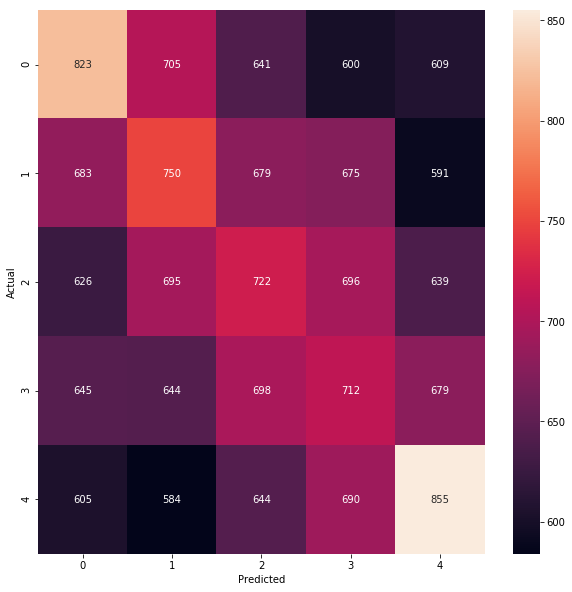

Power_divergenceResult(statistic=array([44.58781786, 23.92717584,  7.17316785, 11.35369108, 66.88882301]), pvalue=array([4.84306999e-09, 8.26047458e-05, 1.27015212e-01, 2.28638119e-02,
       1.02895268e-13]))
[[0.64849023 0.15150977]
 [0.15127294 0.04872706]]
[[ 0.00849023 -0.00849023]
 [-0.00872706  0.00872706]]
Power_divergenceResult(statistic=49.71072010065127, pvalue=9.206748135599743e-11)
[[0.64440497 0.15559503]
 [0.15559503 0.04440497]]
[[ 0.00440497 -0.00440497]
 [-0.00440497  0.00440497]]
Power_divergenceResult(statistic=12.801953818827709, pvalue=0.0050850669207166905)
[[0.64239195 0.15760805]
 [0.15725281 0.04274719]]
[[ 0.00239195 -0.00239195]
 [-0.00274719  0.00274719]]
Power_divergenceResult(statistic=4.738380698638247, pvalue=0.19198760933310116)
[[0.64245115 0.15754885]
 [0.15784488 0.04215512]]
[[ 0.00245115 -0.00245115]
 [-0.00215512  0.00215512]]
Power_divergenceResult(statistic=3.2442458555358202, pvalue=0.35547827102987334)
[[0.6509177  0.1490823 ]
 [0.14937833 0.

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0667991
yearly_vol,0.0845866
yearly_sharpe,0.809768
max_drawdown,-0.0835745
sortino,0.611755


In [20]:
# LASSO each timestep
# have to pass a create_model function in because it needs to recreate model with different coef_dict each timestep
    
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param=coef_dict_paper, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')


In [21]:
def mychart(args, names=None):
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
                tracelabel=names[i]
        plotdata.append(Scatter(x=x_coords,
                                y=args[i].reshape(-1),
                                mode = 'line',
                                name=tracelabel))    

    layout = Layout(
        autosize=False,
        width=600,
        height=480,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    


In [22]:
perf_post_LASSO = backtestmodel.cumulative_return
mychart([perf_post_LASSO],["Post-LASSO"])


................................................................................
22:31:57 Still training step 80 of 563
................................................................................
22:32:06 Still training step 160 of 563
................................................................................
22:32:20 Still training step 240 of 563
................................................................................
22:32:37 Still training step 320 of 563
................................................................................
22:32:59 Still training step 400 of 563
................................................................................
22:33:19 Still training step 480 of 563
................................................................................
22:33:37 Still training step 560 of 563
...
MSE across all predictions: 41.4734
Variance: 39.4097
R-squared: -0.0524


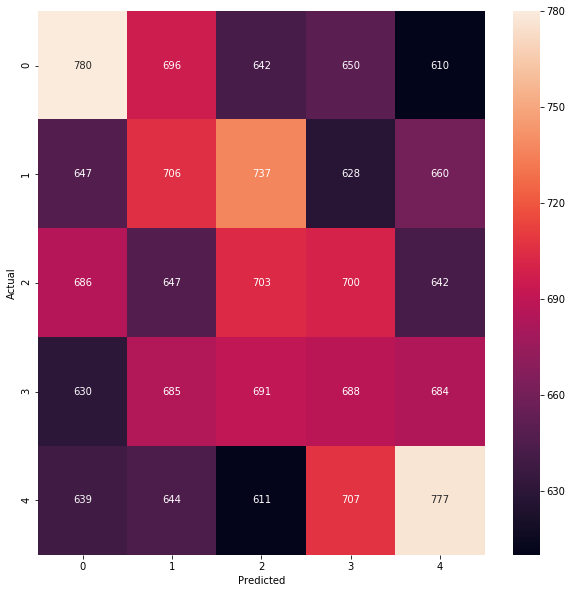

Power_divergenceResult(statistic=array([22.53282082,  4.80343398, 14.8534279 ,  6.89475245, 23.75214942]), pvalue=array([1.56955891e-04, 3.08067399e-01, 5.01507423e-03, 1.41555712e-01,
       8.95508628e-05]))
[[0.64594435 0.15405565]
 [0.15381883 0.04618117]]
[[ 0.00594435 -0.00594435]
 [-0.00618117  0.00618117]]
Power_divergenceResult(statistic=24.828670811130845, pvalue=1.6767919635972718e-05)
[[0.64179988 0.15820012]
 [0.15820012 0.04179988]]
[[ 0.00179988 -0.00179988]
 [-0.00179988  0.00179988]]
Power_divergenceResult(statistic=2.1373593842510363, pvalue=0.54439175751988)
[[0.64126702 0.15873298]
 [0.15837774 0.04162226]]
[[ 0.00126702 -0.00126702]
 [-0.00162226  0.00162226]]
Power_divergenceResult(statistic=1.6008917998815866, pvalue=0.6591876269701693)
[[0.6410302  0.1589698 ]
 [0.15926584 0.04073416]]
[[ 0.0010302  -0.0010302 ]
 [-0.00073416  0.00073416]]
Power_divergenceResult(statistic=0.42453004736530486, pvalue=0.9351298222546277)
[[0.64629959 0.15370041]
 [0.15399645 0.046

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0355146
yearly_vol,0.0476641
yearly_sharpe,0.760555
max_drawdown,-0.128334
sortino,0.329118


In [23]:
# do subset selection at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')



In [24]:
perf_LASSO_each_timestep = backtestmodel.cumulative_return
mychart([perf_LASSO_each_timestep],["LASSO each timestep"])


................................................................................
22:33:40 Still training step 80 of 563
................................................................................
22:33:42 Still training step 160 of 563
................................................................................
22:33:44 Still training step 240 of 563
................................................................................
22:33:46 Still training step 320 of 563
................................................................................
22:33:48 Still training step 400 of 563
................................................................................
22:33:50 Still training step 480 of 563
................................................................................
22:33:52 Still training step 560 of 563
...
MSE across all predictions: 43.8692
Variance: 39.4097
R-squared: -0.1132


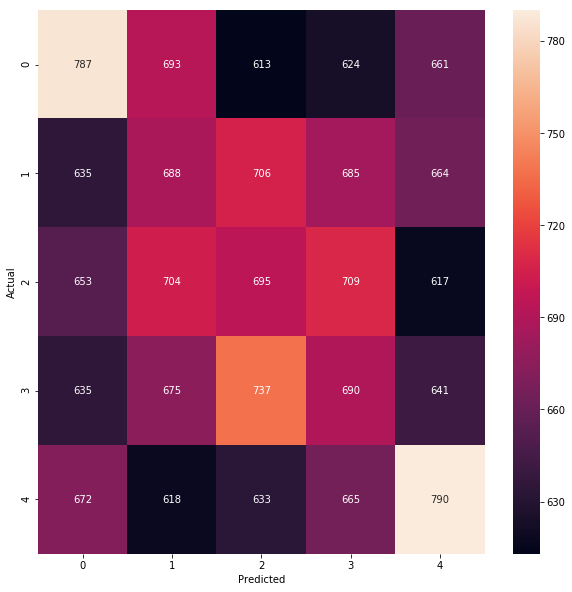

Power_divergenceResult(statistic=array([23.99053814,  6.78093546, 15.95271868,  6.19804328, 26.77319893]), pvalue=array([8.02243320e-05, 1.47927651e-01, 3.08326877e-03, 1.84838405e-01,
       2.20918392e-05]))
[[0.64635879 0.15364121]
 [0.15340438 0.04659562]]
[[ 0.00635879 -0.00635879]
 [-0.00659562  0.00659562]]
Power_divergenceResult(statistic=28.296421699230315, pvalue=3.1471860903044303e-06)
[[0.64073416 0.15926584]
 [0.15926584 0.04073416]]
[[ 0.00073416 -0.00073416]
 [-0.00073416  0.00073416]]
Power_divergenceResult(statistic=0.3556098283007697, pvalue=0.9492517855652362)
[[0.64079337 0.15920663]
 [0.15885139 0.04114861]]
[[ 0.00079337 -0.00079337]
 [-0.00114861  0.00114861]]
Power_divergenceResult(statistic=0.7793997927767911, pvalue=0.8543877178977386)
[[0.64114861 0.15885139]
 [0.15914742 0.04085258]]
[[ 0.00114861 -0.00114861]
 [-0.00085258  0.00085258]]
Power_divergenceResult(statistic=0.5577449674363528, pvalue=0.9060337929535673)
[[0.64706927 0.15293073]
 [0.15322676 0.04

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0278631
yearly_vol,0.0601275
yearly_sharpe,0.489589
max_drawdown,-0.16111
sortino,0.222994


In [25]:
# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')


In [26]:
perf_all_preds = backtestmodel.cumulative_return
mychart([perf_all_preds],["All preds"])


................................................................................
22:34:01 Still training step 80 of 563
................................................................................
22:34:09 Still training step 160 of 563
................................................................................
22:34:21 Still training step 240 of 563
................................................................................
22:34:34 Still training step 320 of 563
................................................................................
22:34:47 Still training step 400 of 563
................................................................................
22:35:02 Still training step 480 of 563
................................................................................
22:35:15 Still training step 560 of 563
...
MSE across all predictions: 40.0227
Variance: 39.4097
R-squared: -0.0156


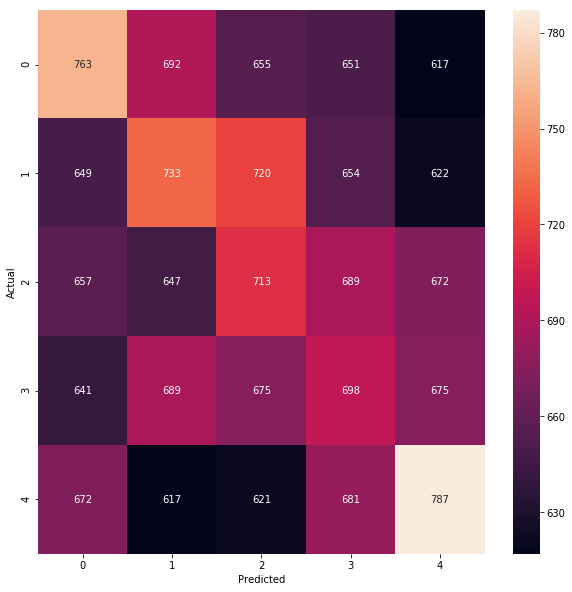

Power_divergenceResult(statistic=array([14.63512714, 11.83422143, 10.00118203,  2.63445004, 27.75748592]), pvalue=array([5.52101146e-03, 1.86275696e-02, 4.04077755e-02, 6.20732738e-01,
       1.39670523e-05]))
[[0.64493783 0.15506217]
 [0.15482534 0.04517466]]
[[ 0.00493783 -0.00493783]
 [-0.00517466  0.00517466]]
Power_divergenceResult(statistic=17.350595766725846, pvalue=0.0005985766743733194)
[[0.64339846 0.15660154]
 [0.15660154 0.04339846]]
[[ 0.00339846 -0.00339846]
 [-0.00339846  0.00339846]]
Power_divergenceResult(statistic=7.619985938425103, pvalue=0.05455433902420572)
[[0.64185909 0.15814091]
 [0.15778567 0.04221433]]
[[ 0.00185909 -0.00185909]
 [-0.00221433  0.00221433]]
Power_divergenceResult(statistic=3.0440534339846064, pvalue=0.38488274967310443)
[[0.64162226 0.15837774]
 [0.15867377 0.04132623]]
[[ 0.00162226 -0.00162226]
 [-0.00132623  0.00132623]]
Power_divergenceResult(statistic=1.2756253700414444, pvalue=0.7349290494598235)
[[0.64689165 0.15310835]
 [0.15340438 0.04

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0308288
yearly_vol,0.0513297
yearly_sharpe,0.600014
max_drawdown,-0.193
sortino,0.284762


In [27]:
# pure LASSO, not LASSO followed by OLS on selected subset
def create_model_lasso():
    return LassoLarsIC(criterion='aic')    
    
# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model_lasso, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')


In [28]:
perf_LASSO_only = backtestmodel.cumulative_return
mychart([perf_LASSO_only],["LASSO only"])

##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.########

##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.########

##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.##############################.########

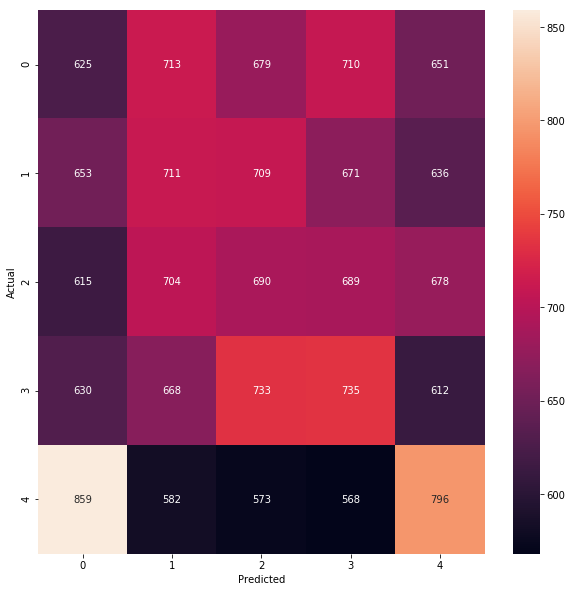

Power_divergenceResult(statistic=array([62.76641041, 18.1722913 , 22.38297872, 24.4369997 , 30.70738215]), pvalue=array([7.59918447e-13, 1.14199005e-03, 1.68133669e-04, 6.52762366e-05,
       3.51230707e-06]))
[[0.63676732 0.16323268]
 [0.16299586 0.03700414]]
[[-0.00323268  0.00323268]
 [ 0.00299586 -0.00299586]]
Power_divergenceResult(statistic=6.116137507400829, pvalue=0.10609458449501982)
[[0.6419775  0.15790409]
 [0.1580225  0.04209591]]
[[ 0.0019775  -0.00209591]
 [-0.0019775   0.00209591]]
Power_divergenceResult(statistic=2.8346099763173473, pvalue=0.4178341438759402)
[[0.64061575 0.15950266]
 [0.15902901 0.04085258]]
[[ 0.00061575 -0.00049734]
 [-0.00097099  0.00085258]]
Power_divergenceResult(statistic=0.4425695677915926, pvalue=0.9313147984204587)
[[0.64381291 0.15618709]
 [0.15648313 0.04351687]]
[[ 0.00381291 -0.00381291]
 [-0.00351687  0.00351687]]
Power_divergenceResult(statistic=8.446566015393724, pvalue=0.037630157425337964)
[[0.64742451 0.15257549]
 [0.15287152 0.04712

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,-0.0113097
yearly_vol,0.0557364
yearly_sharpe,-0.166874
max_drawdown,-0.422417
sortino,-0.0700647


In [29]:
# empty static coef_dict, prediction = mean to date at each timestep
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param=[[]] * npredictors, 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.report_returns(start_date=start_date_str, freq='M')


In [30]:
perf_means = backtestmodel.cumulative_return
mychart([perf_means],["Means"])

In [31]:
mychart([perf_LASSO_each_timestep, perf_all_preds, perf_LASSO_only],["LASSO / OLS", "OLS Only", "LASSO only"])

In [32]:
# double check results_post_LASSO
#model = LinearRegression()
#R = run_backtest(X, Y, model, coef_dict_paper, startmonth=STARTMONTH, summary=False)
#results_post_LASSO = R[FIRST_PREDICT_MONTH:]
#print(len(results_post_LASSO))
#print(results_post_LASSO)
#print(np.mean(results_post_LASSO))
#print(np.std(results_post_LASSO) * np.sqrt(12))
#print(np.prod(1 + results_post_LASSO / 100))
#print(np.prod(1 + results_post_LASSO / 100) ** (12.0/len(results_post_LASSO))-1)

In [33]:
# walk-forward xval
backtestmodel = BacktestModel(X, Y, 
                              create_model=LinearRegression, 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)

backtestmodel.walkforward_xval(n_splits=5, verbose=True)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=False)


22:35:19 Generate splits [137, 274, 411, 548, 684]
Steps: [137, 274, 411, 548]
Training on first 137 rows (0:136), putting predictions in rows [137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273]
.Training on first 274 rows (0:273), putting predictions in rows [274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 

0.005201096892138929

In [34]:
backtestmodel.gen_returns(calc_returns, verbose=False)
retframe = backtestmodel.report_returns(start_date=start_date_str, freq='M')
retframe

Food: long 95 times, short 65 times, total 160 times
Beer: long 119 times, short 77 times, total 196 times
Smoke: long 180 times, short 128 times, total 308 times
Games: long 148 times, short 130 times, total 278 times
Books: long 91 times, short 84 times, total 175 times
Hshld: long 136 times, short 108 times, total 244 times
Clths: long 119 times, short 91 times, total 210 times
Hlth: long 115 times, short 106 times, total 221 times
Chems: long 62 times, short 130 times, total 192 times
Txtls: long 131 times, short 105 times, total 236 times
Cnstr: long 78 times, short 84 times, total 162 times
Steel: long 32 times, short 144 times, total 176 times
FabPr: long 41 times, short 95 times, total 136 times
ElcEq: long 116 times, short 88 times, total 204 times
Autos: long 87 times, short 136 times, total 223 times
Carry: long 131 times, short 106 times, total 237 times
Mines: long 133 times, short 90 times, total 223 times
Coal: long 196 times, short 153 times, total 349 times
Oil: long 1

,Value
start,1970-01-31 00:00:00
end,2015-07-31 00:00:00
cagr,0.0286666
yearly_vol,0.0550099
yearly_sharpe,0.534238
max_drawdown,-0.184168
sortino,0.28887


In [35]:
# closure to wrap model creation function - return a function to create model
def create_model(n_hidden_layers, layer_size, reg_penalty):
    def myclosure():
        return MLPRegressor(hidden_layer_sizes=tuple([layer_size]*n_hidden_layers),
                            alpha=reg_penalty,
                            activation='tanh',
                            max_iter=10000, 
                            tol=1e-10,
                            solver='lbfgs')
    return myclosure

# use all predictors at each timestep 
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(3,2,1.0), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.walkforward_xval(n_splits=5)
backtestmodel.gen_returns(calc_returns, verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=False, verbose=True)
retframe = backtestmodel.report_returns(start_date=start_date_str, freq='M')
retframe
# MSE is a bit worse than LinearRegression

22:35:20 Generate splits [137, 274, 411, 548, 684]
....
Food: long 100 times, short 92 times, total 192 times
Beer: long 60 times, short 104 times, total 164 times
Smoke: long 127 times, short 144 times, total 271 times
Games: long 232 times, short 124 times, total 356 times
Books: long 120 times, short 102 times, total 222 times
Hshld: long 102 times, short 99 times, total 201 times
Clths: long 123 times, short 89 times, total 212 times
Hlth: long 97 times, short 106 times, total 203 times
Chems: long 65 times, short 115 times, total 180 times
Txtls: long 143 times, short 101 times, total 244 times
Cnstr: long 97 times, short 111 times, total 208 times
Steel: long 107 times, short 126 times, total 233 times
FabPr: long 93 times, short 131 times, total 224 times
ElcEq: long 75 times, short 116 times, total 191 times
Autos: long 99 times, short 111 times, total 210 times
Carry: long 91 times, short 93 times, total 184 times
Mines: long 160 times, short 100 times, total 260 times
Coal: l

,Value
start,1970-01-31 00:00:00
end,2015-07-31 00:00:00
cagr,0.015381
yearly_vol,0.0523217
yearly_sharpe,0.319588
max_drawdown,-0.214677
sortino,0.168156


In [36]:
MODELPREFIX = "MLP"

n_hiddens = [1, 2, 3]
layer_sizes = [1, 2, 4, 8]
reg_penalties = [0.0, 0.001, 0.01, 0.1, 1]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
experiments = {}
sharpes = {}
quantile_scores = {}

for counter, param_list in enumerate(hyperparameter_combos):
    n_hidden_layers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_hidden_layers, layer_size, reg_penalty)
    print("%s n_hidden_layers = %d, hidden_layer_size = %d, reg_penalty = %.6f" % 
          (time.strftime("%H:%M:%S"), n_hidden_layers, layer_size, reg_penalty))
    
    experiment_model = BacktestModel(X, Y, 
                                     create_model = create_model(n_hidden_layers,layer_size,reg_penalty), 
                                     coef_dict_param="all", 
                                     startindex=FIRST_TRAIN_MONTHS,
                                     fit_missing='mean',
                                     scaler=None)
    experiment_model.walkforward_xval(n_splits=5)
    score = experiment_model.evaluate_predictions()
    experiments[key] = score
    quantile_score = experiment_model.evaluate_quantiles(chart=False, verbose=False)
    quantile_scores[key] = quantile_score

    experiment_model.gen_returns(calc_returns, verbose=False)
    retframe = experiment_model.report_returns(start_date=start_date_str, freq='M')
    sharpe = retframe.loc['yearly_sharpe']
    sharpes[key] = sharpe.values[0]
    
    print("%s MSE: %f" % (str(key), score))
    print("%s Quantile score: %f" % (str(key), quantile_score))
    print("%s Sharpe: %f" % (str(key), sharpe))



22:38:09 Running 60 experiments
22:38:09 Running experiment 1 of 60
22:38:09 n_hidden_layers = 1, hidden_layer_size = 1, reg_penalty = 0.000000
22:38:09 Generate splits [137, 274, 411, 548, 684]
....
MSE across all predictions: 41.8614
Variance: 39.6015
R-squared: -0.0571
Food: long 75 times, short 63 times, total 138 times
Beer: long 64 times, short 76 times, total 140 times
Smoke: long 286 times, short 100 times, total 386 times
Games: long 254 times, short 193 times, total 447 times
Books: long 177 times, short 147 times, total 324 times
Hshld: long 59 times, short 131 times, total 190 times
Clths: long 260 times, short 194 times, total 454 times
Hlth: long 101 times, short 86 times, total 187 times
Chems: long 40 times, short 152 times, total 192 times
Txtls: long 155 times, short 61 times, total 216 times
Cnstr: long 10 times, short 22 times, total 32 times
Steel: long 11 times, short 220 times, total 231 times
FabPr: long 31 times, short 109 times, total 140 times
ElcEq: long 122

....
MSE across all predictions: 46.3454
Variance: 39.6015
R-squared: -0.1703
Food: long 101 times, short 101 times, total 202 times
Beer: long 117 times, short 107 times, total 224 times
Smoke: long 148 times, short 110 times, total 258 times
Games: long 133 times, short 132 times, total 265 times
Books: long 86 times, short 81 times, total 167 times
Hshld: long 109 times, short 102 times, total 211 times
Clths: long 105 times, short 106 times, total 211 times
Hlth: long 72 times, short 75 times, total 147 times
Chems: long 98 times, short 121 times, total 219 times
Txtls: long 119 times, short 98 times, total 217 times
Cnstr: long 80 times, short 77 times, total 157 times
Steel: long 78 times, short 156 times, total 234 times
FabPr: long 101 times, short 128 times, total 229 times
ElcEq: long 122 times, short 112 times, total 234 times
Autos: long 102 times, short 143 times, total 245 times
Carry: long 100 times, short 103 times, total 203 times
Mines: long 167 times, short 130 times

....
MSE across all predictions: 54.2486
Variance: 39.6015
R-squared: -0.3699
Food: long 93 times, short 88 times, total 181 times
Beer: long 115 times, short 85 times, total 200 times
Smoke: long 111 times, short 107 times, total 218 times
Games: long 134 times, short 110 times, total 244 times
Books: long 97 times, short 63 times, total 160 times
Hshld: long 89 times, short 97 times, total 186 times
Clths: long 109 times, short 98 times, total 207 times
Hlth: long 83 times, short 103 times, total 186 times
Chems: long 69 times, short 108 times, total 177 times
Txtls: long 112 times, short 94 times, total 206 times
Cnstr: long 113 times, short 94 times, total 207 times
Steel: long 95 times, short 151 times, total 246 times
FabPr: long 110 times, short 140 times, total 250 times
ElcEq: long 115 times, short 134 times, total 249 times
Autos: long 82 times, short 113 times, total 195 times
Carry: long 112 times, short 90 times, total 202 times
Mines: long 167 times, short 138 times, tota

....
MSE across all predictions: 71.7011
Variance: 39.6015
R-squared: -0.8106
Food: long 93 times, short 68 times, total 161 times
Beer: long 120 times, short 99 times, total 219 times
Smoke: long 123 times, short 119 times, total 242 times
Games: long 150 times, short 122 times, total 272 times
Books: long 110 times, short 119 times, total 229 times
Hshld: long 81 times, short 102 times, total 183 times
Clths: long 139 times, short 126 times, total 265 times
Hlth: long 79 times, short 91 times, total 170 times
Chems: long 112 times, short 117 times, total 229 times
Txtls: long 108 times, short 92 times, total 200 times
Cnstr: long 88 times, short 90 times, total 178 times
Steel: long 103 times, short 118 times, total 221 times
FabPr: long 91 times, short 100 times, total 191 times
ElcEq: long 116 times, short 85 times, total 201 times
Autos: long 95 times, short 124 times, total 219 times
Carry: long 152 times, short 116 times, total 268 times
Mines: long 137 times, short 105 times, t

....
MSE across all predictions: 41.2129
Variance: 39.6015
R-squared: -0.0407
Food: long 147 times, short 79 times, total 226 times
Beer: long 122 times, short 80 times, total 202 times
Smoke: long 116 times, short 58 times, total 174 times
Games: long 241 times, short 131 times, total 372 times
Books: long 84 times, short 75 times, total 159 times
Hshld: long 62 times, short 74 times, total 136 times
Clths: long 183 times, short 151 times, total 334 times
Hlth: long 93 times, short 86 times, total 179 times
Chems: long 19 times, short 120 times, total 139 times
Txtls: long 168 times, short 97 times, total 265 times
Cnstr: long 73 times, short 140 times, total 213 times
Steel: long 61 times, short 208 times, total 269 times
FabPr: long 46 times, short 126 times, total 172 times
ElcEq: long 13 times, short 20 times, total 33 times
Autos: long 34 times, short 71 times, total 105 times
Carry: long 95 times, short 83 times, total 178 times
Mines: long 210 times, short 117 times, total 327 

....
MSE across all predictions: 45.2323
Variance: 39.6015
R-squared: -0.1422
Food: long 88 times, short 95 times, total 183 times
Beer: long 80 times, short 90 times, total 170 times
Smoke: long 169 times, short 115 times, total 284 times
Games: long 146 times, short 133 times, total 279 times
Books: long 105 times, short 98 times, total 203 times
Hshld: long 88 times, short 104 times, total 192 times
Clths: long 129 times, short 125 times, total 254 times
Hlth: long 109 times, short 136 times, total 245 times
Chems: long 67 times, short 128 times, total 195 times
Txtls: long 154 times, short 86 times, total 240 times
Cnstr: long 105 times, short 99 times, total 204 times
Steel: long 83 times, short 131 times, total 214 times
FabPr: long 74 times, short 56 times, total 130 times
ElcEq: long 107 times, short 68 times, total 175 times
Autos: long 55 times, short 133 times, total 188 times
Carry: long 114 times, short 141 times, total 255 times
Mines: long 163 times, short 157 times, tot

....
MSE across all predictions: 55.4470
Variance: 39.6015
R-squared: -0.4001
Food: long 104 times, short 90 times, total 194 times
Beer: long 75 times, short 98 times, total 173 times
Smoke: long 167 times, short 94 times, total 261 times
Games: long 118 times, short 92 times, total 210 times
Books: long 102 times, short 100 times, total 202 times
Hshld: long 96 times, short 117 times, total 213 times
Clths: long 123 times, short 113 times, total 236 times
Hlth: long 115 times, short 103 times, total 218 times
Chems: long 77 times, short 124 times, total 201 times
Txtls: long 139 times, short 89 times, total 228 times
Cnstr: long 108 times, short 108 times, total 216 times
Steel: long 87 times, short 126 times, total 213 times
FabPr: long 108 times, short 121 times, total 229 times
ElcEq: long 119 times, short 105 times, total 224 times
Autos: long 116 times, short 125 times, total 241 times
Carry: long 120 times, short 140 times, total 260 times
Mines: long 123 times, short 103 times

....
MSE across all predictions: 84.6675
Variance: 39.6015
R-squared: -1.1380
Food: long 92 times, short 86 times, total 178 times
Beer: long 97 times, short 94 times, total 191 times
Smoke: long 126 times, short 132 times, total 258 times
Games: long 133 times, short 108 times, total 241 times
Books: long 73 times, short 118 times, total 191 times
Hshld: long 118 times, short 124 times, total 242 times
Clths: long 102 times, short 76 times, total 178 times
Hlth: long 108 times, short 80 times, total 188 times
Chems: long 81 times, short 92 times, total 173 times
Txtls: long 152 times, short 85 times, total 237 times
Cnstr: long 104 times, short 116 times, total 220 times
Steel: long 99 times, short 135 times, total 234 times
FabPr: long 121 times, short 85 times, total 206 times
ElcEq: long 120 times, short 130 times, total 250 times
Autos: long 113 times, short 94 times, total 207 times
Carry: long 117 times, short 128 times, total 245 times
Mines: long 124 times, short 94 times, tot

....
MSE across all predictions: 40.7568
Variance: 39.6015
R-squared: -0.0292
Food: long 148 times, short 68 times, total 216 times
Beer: long 172 times, short 107 times, total 279 times
Smoke: long 200 times, short 48 times, total 248 times
Games: long 293 times, short 192 times, total 485 times
Books: long 77 times, short 125 times, total 202 times
Hshld: long 49 times, short 47 times, total 96 times
Clths: long 160 times, short 142 times, total 302 times
Hlth: long 68 times, short 73 times, total 141 times
Chems: long 36 times, short 161 times, total 197 times
Txtls: long 184 times, short 79 times, total 263 times
Cnstr: long 42 times, short 110 times, total 152 times
Steel: long 3 times, short 245 times, total 248 times
FabPr: long 36 times, short 145 times, total 181 times
ElcEq: long 14 times, short 47 times, total 61 times
Autos: long 80 times, short 118 times, total 198 times
Carry: long 125 times, short 107 times, total 232 times
Mines: long 243 times, short 105 times, total 3

....
MSE across all predictions: 46.1248
Variance: 39.6015
R-squared: -0.1647
Food: long 90 times, short 89 times, total 179 times
Beer: long 128 times, short 131 times, total 259 times
Smoke: long 145 times, short 130 times, total 275 times
Games: long 116 times, short 121 times, total 237 times
Books: long 147 times, short 92 times, total 239 times
Hshld: long 118 times, short 134 times, total 252 times
Clths: long 140 times, short 169 times, total 309 times
Hlth: long 98 times, short 137 times, total 235 times
Chems: long 69 times, short 116 times, total 185 times
Txtls: long 134 times, short 74 times, total 208 times
Cnstr: long 69 times, short 74 times, total 143 times
Steel: long 81 times, short 164 times, total 245 times
FabPr: long 92 times, short 113 times, total 205 times
ElcEq: long 111 times, short 109 times, total 220 times
Autos: long 85 times, short 81 times, total 166 times
Carry: long 133 times, short 89 times, total 222 times
Mines: long 101 times, short 62 times, tot

....
MSE across all predictions: 58.7211
Variance: 39.6015
R-squared: -0.4828
Food: long 80 times, short 95 times, total 175 times
Beer: long 70 times, short 71 times, total 141 times
Smoke: long 142 times, short 127 times, total 269 times
Games: long 152 times, short 72 times, total 224 times
Books: long 98 times, short 76 times, total 174 times
Hshld: long 64 times, short 131 times, total 195 times
Clths: long 121 times, short 126 times, total 247 times
Hlth: long 92 times, short 114 times, total 206 times
Chems: long 59 times, short 116 times, total 175 times
Txtls: long 127 times, short 95 times, total 222 times
Cnstr: long 102 times, short 99 times, total 201 times
Steel: long 68 times, short 122 times, total 190 times
FabPr: long 108 times, short 128 times, total 236 times
ElcEq: long 128 times, short 109 times, total 237 times
Autos: long 121 times, short 128 times, total 249 times
Carry: long 120 times, short 136 times, total 256 times
Mines: long 162 times, short 133 times, to

....
MSE across all predictions: 85.2924
Variance: 39.6015
R-squared: -1.1538
Food: long 82 times, short 113 times, total 195 times
Beer: long 86 times, short 73 times, total 159 times
Smoke: long 129 times, short 124 times, total 253 times
Games: long 153 times, short 135 times, total 288 times
Books: long 94 times, short 100 times, total 194 times
Hshld: long 90 times, short 95 times, total 185 times
Clths: long 116 times, short 114 times, total 230 times
Hlth: long 104 times, short 111 times, total 215 times
Chems: long 117 times, short 85 times, total 202 times
Txtls: long 120 times, short 107 times, total 227 times
Cnstr: long 103 times, short 112 times, total 215 times
Steel: long 122 times, short 120 times, total 242 times
FabPr: long 128 times, short 117 times, total 245 times
ElcEq: long 106 times, short 98 times, total 204 times
Autos: long 105 times, short 91 times, total 196 times
Carry: long 133 times, short 141 times, total 274 times
Mines: long 124 times, short 113 times

In [37]:
# list and chart experiments
flatlist = [list(l[0]) + [l[1]] for l in experiments.items()]
 
lossframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "MSE"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
lossframe.sort_values(['MSE'])

,n_hidden_layers,layer_size,reg_penalty,MSE
38,3,1,0.000,40.756810
43,3,1,0.010,41.057414
31,3,1,0.001,41.208182
49,2,1,0.000,41.212949
50,2,1,0.001,41.263813
55,1,1,0.001,41.588441
56,2,1,0.010,41.656519
47,1,1,0.000,41.861352
15,2,1,0.100,42.000528
35,3,1,1.000,42.144745


In [38]:
# list sharpes
flatlist = [list(l[0]) + [l[1]] for l in sharpes.items()]
 
sharpeframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "sharpe"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
sharpeframe.sort_values(['sharpe'])

,n_hidden_layers,layer_size,reg_penalty,sharpe
21,3,8,1.000,-0.160617
7,2,4,1.000,-0.075304
40,3,4,0.000,-0.020475
37,3,4,0.010,-0.000031
22,3,8,0.000,0.016973
24,3,8,0.010,0.032659
20,1,4,0.001,0.042003
42,1,8,1.000,0.066780
30,1,2,0.000,0.078570
9,3,4,1.000,0.087276


In [39]:
# list quantile scores
flatlist = [list(l[0]) + [l[1]] for l in quantile_scores.items()]
 
qframe = pd.DataFrame(flatlist, columns=["n_hidden_layers", "layer_size", "reg_penalty", "qscore"])
# one row didn't converge properly - messes up plotly scales
#for i in list(lossframe.loc[lossframe['loss']> 1000].index):
#    lossframe.at[i, 'loss'] = 100
#list(l) +
qframe.sort_values(['qscore'])

,n_hidden_layers,layer_size,reg_penalty,qscore
7,2,4,1.000,-0.000923
9,3,4,1.000,0.000356
25,2,8,0.100,0.000417
13,3,4,0.001,0.000600
24,3,8,0.010,0.000631
32,3,2,0.000,0.000661
18,2,4,0.000,0.000722
42,1,8,1.000,0.000722
40,3,4,0.000,0.000753
11,2,8,0.001,0.000783


In [40]:
sharpes_array = sharpeframe.values[:,3]
print(sharpes_array.shape)
mses_array = lossframe.values[:,3]
print(mses_array.shape)
qscore_array = qframe.values[:,3]
print(qscore_array.shape)

(60,)
(60,)
(60,)


In [41]:
def myscatter(arg1, arg2, names=None):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))
    
    layout = Layout(
        autosize=False,
        width=600,
        height=480,
        yaxis=dict(
            type='log',
            autorange=True
        )
    )
    
    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)
    
myscatter(sharpes_array, mses_array)
# MSEs worse than linear regression
# no very good Sharpes
# weak correlation between MSEs, Sharpes, which is perplexing

In [42]:
myscatter(sharpes_array, qscore_array)


In [43]:
# we can pick lowest loss , but first we look at patterns by hyperparameter
pd.DataFrame(lossframe.groupby(['n_hidden_layers'])['MSE'].mean())


,MSE
n_hidden_layers,
1,56.179426
2,57.819897
3,59.397585


In [44]:
pd.DataFrame(lossframe.groupby(['layer_size'])['MSE'].mean())


,MSE
layer_size,
1,41.813392
2,46.821903
4,59.519026
8,83.041558


In [45]:
pd.DataFrame(lossframe.groupby(['reg_penalty'])['MSE'].mean())


,MSE
reg_penalty,
0.000,55.967604
0.001,56.119740
0.010,57.527457
0.100,59.506228
1.000,59.873819


In [46]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['MSE'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = Layout(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

plot_matrix(lossframe, "n_hidden_layers", "layer_size", x_suffix=" layers", y_suffix=" units")




In [47]:
plot_matrix(lossframe, "n_hidden_layers", "reg_penalty", x_suffix=" layers", y_suffix=" p")


In [48]:
plot_matrix(lossframe, "reg_penalty", "layer_size", x_suffix=" p", y_suffix="units")


In [23]:
def create_model(n_hidden_layers, layer_size, reg_penalty):
    def myclosure():
        return MLPRegressor(hidden_layer_sizes=tuple([layer_size]*n_hidden_layers),
                            alpha=reg_penalty,
                            activation='tanh',
                            max_iter=10000, 
                            tol=1e-10,
                            solver='lbfgs')
    return myclosure

................................................................................
01:30:36 Still training step 80 of 563
................................................................................
01:32:47 Still training step 160 of 563
................................................................................
01:36:38 Still training step 240 of 563
................................................................................
01:40:57 Still training step 320 of 563
................................................................................
01:44:57 Still training step 400 of 563
................................................................................
01:49:01 Still training step 480 of 563
................................................................................
01:52:59 Still training step 560 of 563
...
MSE across all predictions: 41.3304
Variance: 39.4097
R-squared: -0.0487


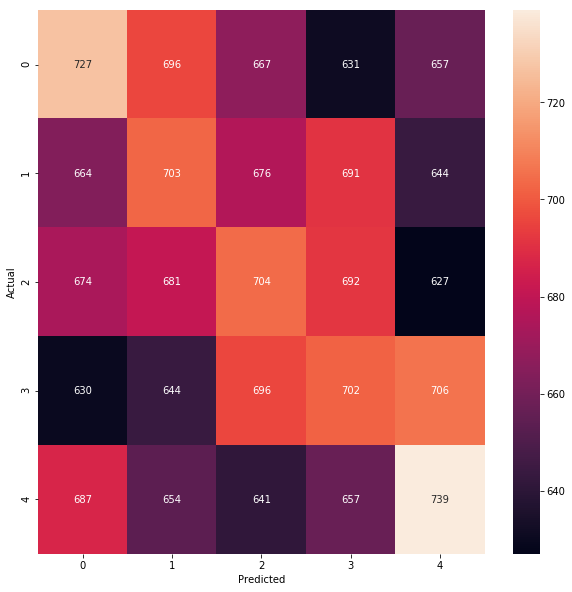

Power_divergenceResult(statistic=array([ 7.37019515,  3.93901717,  3.67434988,  5.23747406, 12.81529795]), pvalue=array([0.11757124, 0.41432189, 0.45186757, 0.26378736, 0.01221445]))
[[0.64280639 0.15719361]
 [0.15695678 0.04304322]]
[[ 0.00280639 -0.00280639]
 [-0.00304322  0.00304322]]
Power_divergenceResult(statistic=5.927416370633511, pvalue=0.11519547415318576)
[[0.64162226 0.15837774]
 [0.15837774 0.04162226]]
[[ 0.00162226 -0.00162226]
 [-0.00162226  0.00162226]]
Power_divergenceResult(statistic=1.7363269686204854, pvalue=0.6288879072394806)
[[0.64132623 0.15867377]
 [0.15831853 0.04168147]]
[[ 0.00132623 -0.00132623]
 [-0.00168147  0.00168147]]
Power_divergenceResult(statistic=1.7243931320307873, pvalue=0.6315243306908258)
[[0.64185909 0.15814091]
 [0.15843694 0.04156306]]
[[ 0.00185909 -0.00185909]
 [-0.00156306  0.00156306]]
Power_divergenceResult(statistic=1.7455780047365304, pvalue=0.6268487501332118)
[[0.64404973 0.15595027]
 [0.1562463  0.0437537 ]]
[[ 0.00404973 -0.00404

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0116774
yearly_vol,0.0484827
yearly_sharpe,0.237193
max_drawdown,-0.192716
sortino,0.12106


In [49]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(3,1,0.0), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
retframe = backtestmodel.report_returns(start_date=start_date_str, freq='M')
retframe

................................................................................
09:20:45 Still training step 80 of 563
................................................................................
09:23:35 Still training step 160 of 563
................................................................................
09:27:40 Still training step 240 of 563
................................................................................
09:32:12 Still training step 320 of 563
................................................................................
09:36:29 Still training step 400 of 563
................................................................................
09:40:54 Still training step 480 of 563
................................................................................
09:45:22 Still training step 560 of 563
...
MSE across all predictions: 42.1732
Variance: 39.4097
R-squared: -0.0701


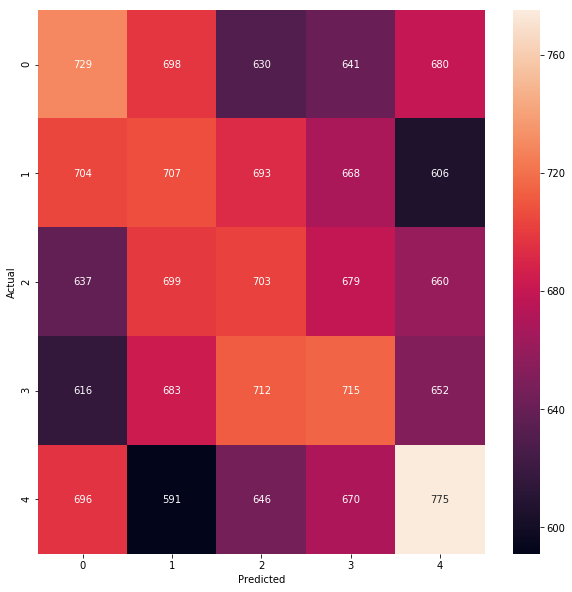

Power_divergenceResult(statistic=array([13.47309284, 13.68738899,  7.87056738,  4.21761044, 23.03468722]), pvalue=array([9.18125813e-03, 8.36261139e-03, 9.64362094e-02, 3.77355811e-01,
       1.24621621e-04]))
[[0.64292481 0.15707519]
 [0.15683837 0.04316163]]
[[ 0.00292481 -0.00292481]
 [-0.00316163  0.00316163]]
Power_divergenceResult(statistic=6.40476983422145, pvalue=0.09349475970825907)
[[0.64185909 0.15814091]
 [0.15814091 0.04185909]]
[[ 0.00185909 -0.00185909]
 [-0.00185909  0.00185909]]
Power_divergenceResult(statistic=2.2802878922439316, pvalue=0.5163077383715216)
[[0.64126702 0.15873298]
 [0.15837774 0.04162226]]
[[ 0.00126702 -0.00126702]
 [-0.00162226  0.00162226]]
Power_divergenceResult(statistic=1.6008917998815866, pvalue=0.6591876269701693)
[[0.64262877 0.15737123]
 [0.15766726 0.04233274]]
[[ 0.00262877 -0.00262877]
 [-0.00233274  0.00233274]]
Power_divergenceResult(statistic=3.7840438129070457, pvalue=0.28574756618242036)
[[0.64618117 0.15381883]
 [0.15411486 0.045885

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.016092
yearly_vol,0.0506844
yearly_sharpe,0.315669
max_drawdown,-0.257745
sortino,0.162184


In [24]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(2,1,1.0), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
retframe = backtestmodel.report_returns(start_date=start_date_str, freq='M')
retframe

................................................................................
09:46:51 Still training step 80 of 563
................................................................................
09:47:47 Still training step 160 of 563
................................................................................
09:48:37 Still training step 240 of 563
................................................................................
09:49:31 Still training step 320 of 563
................................................................................
09:50:39 Still training step 400 of 563
................................................................................
09:51:57 Still training step 480 of 563
................................................................................
09:53:13 Still training step 560 of 563
...
MSE across all predictions: 40.7599
Variance: 39.4097
R-squared: -0.0343


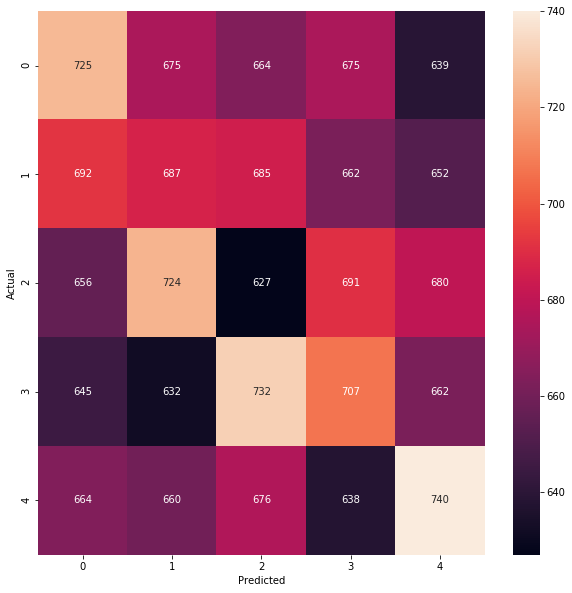

Power_divergenceResult(statistic=array([6.15198108, 6.83422143, 8.50886525, 4.17610436, 9.25466943]), pvalue=array([0.18808209, 0.14491254, 0.07461896, 0.38269703, 0.0550398 ]))
[[0.64268798 0.15731202]
 [0.15707519 0.04292481]]
[[ 0.00268798 -0.00268798]
 [-0.00292481  0.00292481]]
Power_divergenceResult(statistic=5.468564979277679, pvalue=0.14053091570946036)
[[0.64067496 0.15932504]
 [0.15932504 0.04067496]]
[[ 0.00067496 -0.00067496]
 [-0.00067496  0.00067496]]
Power_divergenceResult(statistic=0.30056616341030196, pvalue=0.959921965096484)
[[0.63676732 0.16323268]
 [0.16287744 0.03712256]]
[[-0.00323268  0.00323268]
 [ 0.00287744 -0.00287744]]
Power_divergenceResult(statistic=5.749056394316146, pvalue=0.12447833351251514)
[[0.64215512 0.15784488]
 [0.15814091 0.04185909]]
[[ 0.00215512 -0.00215512]
 [-0.00185909  0.00185909]]
Power_divergenceResult(statistic=2.437092954410894, pvalue=0.48676713282174255)
[[0.64410894 0.15589106]
 [0.15618709 0.04381291]]
[[ 0.00410894 -0.00410894]


,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0131758
yearly_vol,0.0384359
yearly_sharpe,0.333989
max_drawdown,-0.227219
sortino,0.138184


In [25]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(2,1,1.0), 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
retframe = backtestmodel.report_returns(start_date=start_date_str, freq='M')
retframe

................................................................................
09:59:35 Still training step 80 of 563
................................................................................
10:01:48 Still training step 160 of 563
................................................................................
10:05:30 Still training step 240 of 563
................................................................................
10:09:59 Still training step 320 of 563
................................................................................
10:14:14 Still training step 400 of 563
................................................................................
10:18:34 Still training step 480 of 563
................................................................................
10:22:32 Still training step 560 of 563
...
MSE across all predictions: 41.2854
Variance: 39.4097
R-squared: -0.0476


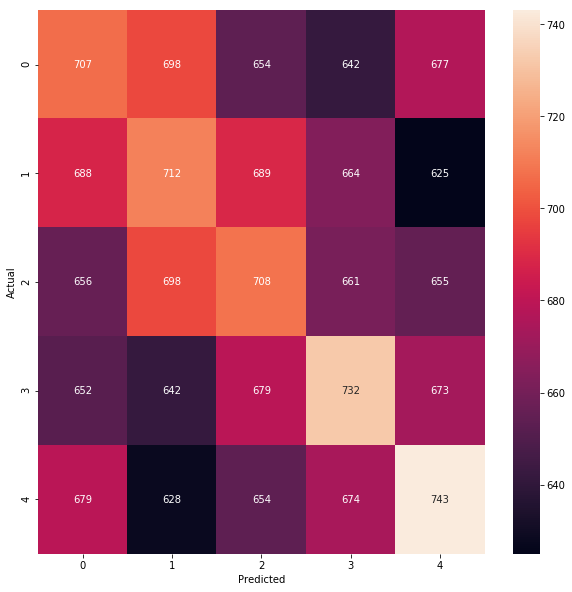

Power_divergenceResult(statistic=array([ 3.08870491,  8.47128478,  3.20153664,  6.90068189, 11.16394901]), pvalue=array([0.54309215, 0.07576242, 0.52468279, 0.14123075, 0.02478195]))
[[0.64162226 0.15837774]
 [0.15814091 0.04185909]]
[[ 0.00162226 -0.00162226]
 [-0.00185909  0.00185909]]
Power_divergenceResult(statistic=2.171495707519242, pvalue=0.5375846282256784)
[[0.64215512 0.15784488]
 [0.15784488 0.04215512]]
[[ 0.00215512 -0.00215512]
 [-0.00215512  0.00215512]]
Power_divergenceResult(statistic=3.0643132030787448, pvalue=0.38181524616294166)
[[0.64156306 0.15843694]
 [0.15808171 0.04191829]]
[[ 0.00156306 -0.00156306]
 [-0.00191829  0.00191829]]
Power_divergenceResult(statistic=2.2646536412078153, pvalue=0.5193261291179028)
[[0.64363529 0.15636471]
 [0.15666075 0.04333925]]
[[ 0.00363529 -0.00363529]
 [-0.00333925  0.00333925]]
Power_divergenceResult(statistic=7.629236974541149, pvalue=0.05432915050827943)
[[0.64428656 0.15571344]
 [0.15600947 0.04399053]]
[[ 0.00428656 -0.00428

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0144361
yearly_vol,0.0396749
yearly_sharpe,0.323796
max_drawdown,-0.164638
sortino,0.155408


In [27]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(3,1,0.0), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
retframe = backtestmodel.report_returns(start_date=start_date_str, freq='M')
retframe

................................................................................
10:23:54 Still training step 80 of 563
................................................................................
10:25:00 Still training step 160 of 563
................................................................................
10:25:59 Still training step 240 of 563
................................................................................
10:26:58 Still training step 320 of 563
................................................................................
10:28:15 Still training step 400 of 563
................................................................................
10:29:38 Still training step 480 of 563
................................................................................
10:31:00 Still training step 560 of 563
...
MSE across all predictions: 40.5984
Variance: 39.4097
R-squared: -0.0302


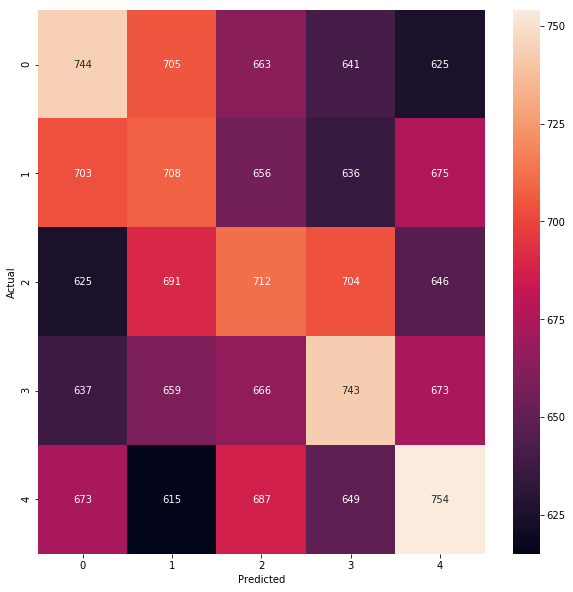

Power_divergenceResult(statistic=array([14.02010645,  9.02782712,  3.07742317, 13.07026386, 14.20871628]), pvalue=array([0.00723116, 0.06040769, 0.54495346, 0.01093753, 0.00665787]))
[[0.64381291 0.15618709]
 [0.15595027 0.04404973]]
[[ 0.00381291 -0.00381291]
 [-0.00404973  0.00404973]]
Power_divergenceResult(statistic=10.574674363528715, pvalue=0.014262800576285898)
[[0.64191829 0.15808171]
 [0.15808171 0.04191829]]
[[ 0.00191829 -0.00191829]
 [-0.00191829  0.00191829]]
Power_divergenceResult(statistic=2.427841918294849, pvalue=0.4884729024236044)
[[0.64179988 0.15820012]
 [0.15784488 0.04215512]]
[[ 0.00179988 -0.00179988]
 [-0.00215512  0.00215512]]
Power_divergenceResult(statistic=2.878922439313203, pvalue=0.41067211642668566)
[[0.64428656 0.15571344]
 [0.15600947 0.04399053]]
[[ 0.00428656 -0.00428656]
 [-0.00399053  0.00399053]]
Power_divergenceResult(statistic=10.829632918886915, pvalue=0.012683704232172523)
[[0.64493783 0.15506217]
 [0.1553582  0.0446418 ]]
[[ 0.00493783 -0.00

,Value
start,1970-01-31 00:00:00
end,2016-11-30 00:00:00
cagr,0.0208362
yearly_vol,0.0476813
yearly_sharpe,0.442933
max_drawdown,-0.129192
sortino,0.209495


In [28]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=create_model(3,1,0.0), 
                              coef_dict_param="timestep", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler=None)
backtestmodel.gen_predictions(verbose=False)
backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
backtestmodel.gen_returns(calc_returns, verbose=False)
retframe = backtestmodel.report_returns(start_date=start_date_str, freq='M')
retframe